In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.2 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 3.3 MB 69.5 MB/s 
     |████████████████████████████████| 636 kB 46.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.legacy import data
from torchtext.legacy import datasets

from transformers import BertTokenizer, BertModel

import numpy as np

import time
import random
import functools

SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, pad_token, unk_token)

[CLS] [PAD] [UNK]


In [7]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

101 0 100


In [8]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


In [9]:
def cut_and_convert_to_id(tokens, tokenizer, max_input_length):
    tokens = tokens[:max_input_length-1]
    tokens = tokenizer.convert_tokens_to_ids(tokens)
    return tokens

In [10]:
def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

In [11]:
text_preprocessor = functools.partial(cut_and_convert_to_id,
                                      tokenizer = tokenizer,
                                      max_input_length = max_input_length)

tag_preprocessor = functools.partial(cut_to_max_length,
                                     max_input_length = max_input_length)

In [12]:
TEXT = data.Field(use_vocab = False,
                  lower = True,
                  preprocessing = text_preprocessor,
                  init_token = init_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

UD_TAGS = data.Field(unk_token = None,
                     init_token = '<pad>',
                     preprocessing = tag_preprocessor)

In [13]:
fields = (("text", TEXT), ("udtags", UD_TAGS))

In [14]:
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

downloading en-ud-v2.zip


en-ud-v2.zip: 100%|██████████| 688k/688k [00:00<00:00, 2.29MB/s]


extracting


In [15]:
print(vars(train_data.examples[0]))

{'text': [2632, 1011, 100, 1024, 2137, 2749, 2730, 100, 14093, 2632, 1011, 100, 1010, 1996, 14512, 2012, 1996, 8806, 1999, 1996, 2237, 1997, 100, 1010, 2379, 1996, 9042, 3675, 1012], 'udtags': ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']}


In [16]:
UD_TAGS.build_vocab(train_data)

print(UD_TAGS.vocab.stoi)

defaultdict(None, {'<pad>': 0, 'NOUN': 1, 'PUNCT': 2, 'VERB': 3, 'PRON': 4, 'ADP': 5, 'DET': 6, 'PROPN': 7, 'ADJ': 8, 'AUX': 9, 'ADV': 10, 'CCONJ': 11, 'PART': 12, 'NUM': 13, 'SCONJ': 14, 'X': 15, 'INTJ': 16, 'SYM': 17})


In [17]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [18]:
class BERTPoSTagger(nn.Module):
    def __init__(self,
                 bert,
                 output_dim, 
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        text = text.permute(1, 0)
        
        embedded = self.dropout(self.bert(text)[0])
                
        embedded = embedded.permute(1, 0, 2)
        
        predictions = self.fc(self.dropout(embedded))
        
        return predictions

In [19]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
OUTPUT_DIM = len(UD_TAGS.vocab)
DROPOUT = 0.25

model = BERTPoSTagger(bert,
                      OUTPUT_DIM, 
                      DROPOUT)

In [22]:
LEARNING_RATE = 5e-5

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [23]:
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [24]:
model = model.to(device)
criterion = criterion.to(device)

In [25]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

In [26]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.udtags
                
        optimizer.zero_grad()
        
        predictions = model(text)
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.udtags
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 57s
	Train Loss: 0.377 | Train Acc: 89.32%
	 Val. Loss: 0.305 |  Val. Acc: 90.59%
Epoch: 02 | Epoch Time: 2m 3s
	Train Loss: 0.113 | Train Acc: 96.73%
	 Val. Loss: 0.268 |  Val. Acc: 92.29%
Epoch: 03 | Epoch Time: 2m 5s
	Train Loss: 0.072 | Train Acc: 97.89%
	 Val. Loss: 0.278 |  Val. Acc: 92.19%
Epoch: 04 | Epoch Time: 2m 6s
	Train Loss: 0.050 | Train Acc: 98.53%
	 Val. Loss: 0.321 |  Val. Acc: 91.93%
Epoch: 05 | Epoch Time: 2m 6s
	Train Loss: 0.036 | Train Acc: 98.94%
	 Val. Loss: 0.288 |  Val. Acc: 92.14%
Epoch: 06 | Epoch Time: 2m 5s
	Train Loss: 0.026 | Train Acc: 99.23%
	 Val. Loss: 0.288 |  Val. Acc: 92.98%
Epoch: 07 | Epoch Time: 2m 6s
	Train Loss: 0.020 | Train Acc: 99.40%
	 Val. Loss: 0.303 |  Val. Acc: 92.73%
Epoch: 08 | Epoch Time: 2m 4s
	Train Loss: 0.017 | Train Acc: 99.50%
	 Val. Loss: 0.322 |  Val. Acc: 92.68%
Epoch: 09 | Epoch Time: 2m 4s
	Train Loss: 0.016 | Train Acc: 99.52%
	 Val. Loss: 0.314 |  Val. Acc: 92.67%
Epoch: 10 | Epoch Time: 2m 

In [30]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.287 | Test Acc: 90.92%


In [31]:
def tag_sentence(model, device, sentence, tokenizer, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        tokens = tokenizer.tokenize(sentence)
    else:
        tokens = sentence
    
    numericalized_tokens = tokenizer.convert_tokens_to_ids(tokens)
    numericalized_tokens = [text_field.init_token] + numericalized_tokens
        
    unk_idx = text_field.unk_token
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    predicted_tags = predicted_tags[1:]
        
    assert len(tokens) == len(predicted_tags)
    
    return tokens, predicted_tags, unks

In [32]:
sentence = '''Frederick Fleet, who was lookout in the crow's nest of the Titanic when the giant liner smashed into the iceberg, made oath that not a single lookout on the Titanic was provided with marine glasses and declared that had his request for such glasses in Southampton not been refused the Titanic might yet be afloat. "I could easily have sighted the iceberg with marine glasses in plenty of time to have the vessel steered out of the way." said Fleet, and gave in detail the request he made in Southampton for them. Although all other liners are so provided, Fleet swore, his request was flatly refused and he was told there were no glasses for him.
Third Officer Pittman admitted that the Titanic had been warned that icebergs were prevalent, but said he did not see any on the Sunday of the disaster. He declared that in his 14 years' experience he had seen only one iceberg before.'''

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence,
                                  tokenizer,
                                  TEXT, 
                                  UD_TAGS)

print(unks)

[]


In [33]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

PROPN		frederick
PROPN		fleet
PUNCT		,
PRON		who
AUX		was
NOUN		lookout
ADP		in
DET		the
NOUN		crow
PART		'
PART		s
NOUN		nest
ADP		of
DET		the
PROPN		titanic
ADV		when
DET		the
ADJ		giant
NOUN		liner
VERB		smashed
ADP		into
DET		the
NOUN		ice
NOUN		##berg
PUNCT		,
VERB		made
NOUN		oath
SCONJ		that
PART		not
DET		a
ADJ		single
NOUN		lookout
ADP		on
DET		the
PROPN		titanic
AUX		was
VERB		provided
ADP		with
ADJ		marine
NOUN		glasses
CCONJ		and
VERB		declared
SCONJ		that
VERB		had
PRON		his
NOUN		request
ADP		for
ADJ		such
NOUN		glasses
ADP		in
PROPN		southampton
PART		not
AUX		been
VERB		refused
DET		the
PROPN		titanic
AUX		might
ADV		yet
AUX		be
ADV		afl
ADV		##oat
PUNCT		.
PUNCT		"
PRON		i
AUX		could
ADV		easily
AUX		have
VERB		sighted
DET		the
NOUN		ice
NOUN		##berg
ADP		with
ADJ		marine
NOUN		glasses
ADP		in
NOUN		plenty
ADP		of
NOUN		time
PART		to
VERB		have
DET		the
NOUN		vessel
VERB		steered
ADP		out
ADP		of
DET		the
NOUN		way
PUNCT		.
PUNCT		"
VERB		said
PROPN		f

# Combine POS with a GRU

In [34]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import string
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torchtext.vocab import GloVe

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

cuda is used


In [35]:
# Read the data
# Internal datasets
training = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/internal_train.csv').to_numpy()
test = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/internal_test.csv').to_numpy()
# Real datasets (Keep only these ones for kaggle (delete test))
blind_test = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/test.csv').to_numpy()
full_training = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/train.csv').to_numpy()

# TODO: Remove to train on full dataset
#training = training[:10, :]

training = np.random.permutation(training)
print(training.shape, test.shape, blind_test.shape, full_training.shape)

(2434, 6) (400, 6) (7, 4) (2834, 6)


In [36]:
training_X = training[:, 3]
training_Y = training[:, 4]
print('training shape =', training_X.shape, training_Y.shape)

full_training_X = full_training[:, 3]
full_training_Y = full_training[:, 4]
print('Real training shape =', full_training_X.shape, full_training_Y.shape)

test_X = test[:, 3]
test_Y = test[:, 4]
print('test shape =', test_X.shape, test_Y.shape)

blind_test_X = blind_test[:, 3]
print('BLIND test shape =', blind_test_X.shape)

training shape = (2434,) (2434,)
Real training shape = (2834,) (2834,)
test shape = (400,) (400,)
BLIND test shape = (7,)


In [37]:

embedding_dim = 300
glove = GloVe(name="840B", dim=embedding_dim)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.30MB/s]                            
100%|█████████▉| 2195067/2196017 [04:00<00:00, 9931.68it/s]

In [38]:
import re
from torchtext.legacy import data, datasets, vocab

n_tags = 0

# Turn a line of words into the curresponding POS tags
def lineToTensor(line):
    # Split a string into array of words and punctation
    # "Much, fun." => ["Much", ",", "fun", "."]

    # words = re.findall(r"[\w']+|[.,!?;]", line)
    # tensor = torch.tensor([glove.stoi[w] for w in words if w in glove.stoi], dtype=torch.long)
    # return tensor

    tokens, tags, unks = tag_sentence(model, device, line,tokenizer,TEXT, UD_TAGS)

    tags_ids = [UD_TAGS.vocab.stoi[tag] for tag in tags]
    global n_tags
    n_tags = len(UD_TAGS.vocab.stoi.keys())

    tensor = torch.zeros(len(tags_ids), 1 + n_tags)
    i = 0
    for (tag, token) in zip(tags_ids, tokens):
        if token in glove.stoi.keys():
            tensor[i, :] = torch.cat((torch.tensor([glove.stoi[token]]), F.one_hot(torch.tensor(tag), num_classes=n_tags)))
            i += 1
    r = torch.zeros(i, 1 + n_tags)
    r = tensor[:i, :]

    return r

print(lineToTensor(training_X[0]))

tensor([[1.0800e+02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.1000e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.5400e+02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.4000e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.7070e+03, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [39]:
# We want the entire dataset encoded with the glove embeddings
# So, the final size will be (n_samples, 1, excerpt_length, embedding_dim) (extra dimension 1 inserted for pytorch batch)
# Since a tensor has fixed size we pad the sequences to ensure all have the same length.
# Get the max excerpt length and encode the training set
max_excerpt_len = len(max(training_X, key=len))
enc_training_X = np.zeros((training_X.shape[0], 1, max_excerpt_len, 1 + n_tags))
training_lengths = []
for i, x in enumerate(training_X):
    enc_x = lineToTensor(x)
    enc_training_X[i, 0, :enc_x.shape[0]] = enc_x
    training_lengths.append(enc_x.shape[0])

print('encoded Training shape =',enc_training_X.shape)


max_excerpt_len = len(max(full_training_X, key=len))
enc_full_training_X = np.zeros((full_training_X.shape[0], 1, max_excerpt_len, 1 + n_tags))
full_training_lengths = []
for i, x in enumerate(full_training_X):
    enc_x = lineToTensor(x)
    enc_full_training_X[i, 0, :enc_x.shape[0]] = enc_x
    full_training_lengths.append(enc_x.shape[0])

print('encoded Real/Full Training shape =',enc_full_training_X.shape)


max_excerpt_len = len(max(test_X, key=len))
enc_test_X = np.zeros((test_X.shape[0], 1, max_excerpt_len, 1 + n_tags))
test_lengths = []
for i, x in enumerate(test_X):
    enc_x = lineToTensor(x)
    enc_test_X[i, 0, :enc_x.shape[0]] = enc_x
    test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_test_X.shape)


max_excerpt_len = len(max(blind_test_X, key=len))
enc_blind_test_X = np.zeros((blind_test_X.shape[0], 1, max_excerpt_len, 1 + n_tags))
blind_test_lengths = []
for i, x in enumerate(blind_test_X):
    enc_x = lineToTensor(x)
    enc_blind_test_X[i, 0, :enc_x.shape[0]] = enc_x
    blind_test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_blind_test_X.shape)

encoded Training shape = (2434, 1, 1341, 19)
encoded Real/Full Training shape = (2834, 1, 1341, 19)
enc. Test shape = (400, 1, 1323, 19)
enc. Test shape = (7, 1, 1144, 19)


In [40]:
from math import floor
#Utility function to get a random sample
def randomTrainingExample():
    i = np.random.randint(0, training_X.shape[0])
    excerpt_tensor = lineToTensor(training_X[i])
    target_tensor = torch.tensor(training_Y[i], dtype=torch.float)
    return excerpt_tensor, target_tensor

randomTrainingExample()

(tensor([[1.2266e+04, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.9000e+01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.1000e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [5.0000e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.2266e+04, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]), tensor(-0.5144))

In [74]:
class CommonLitDataset(Dataset):
    # X: numpy matrix (n_samples, 1, excerpt_length, embedding_dim)
    def __init__(self, X, Y, lengths):
        self.X = X
        self.Y = Y
        self.lengths = lengths

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.zeros(max(self.lengths), embedding_dim + n_tags)
        for i in range(self.lengths[idx]):
            # print(self.X[idx][0].shape) # seq_len x 19
            tok_id = int(self.X[idx][0][i, 0].item())
            glove_emb = glove.vectors[tok_id]
            tagged_seq = self.X[idx][0][i, 1:]
            # Concatenate glove embedding with the POS tagged_seq
            min_length = min(glove_emb.shape[0], tagged_seq.shape[0])
            #glove_emb = glove_emb[:min_length]
            #tagged_seq = tagged_seq[:min_length]
            a = torch.tensor(np.hstack((glove_emb, tagged_seq)))
            x[i, :] = a
        return (x.float(), self.lengths[idx]), torch.tensor(self.Y[idx]).float()

In [77]:
# Define the model

class GRU(nn.Module):
    def __init__(self, hidden_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(n_tags + embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, sequence_length):
        x_pack = pack_padded_sequence(x, sequence_length, batch_first=True, enforce_sorted=False)
        lstm_out, ht = self.gru(x_pack)
        return self.linear(ht[-1])

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim))

def compute_mse(model, generator):
    model.eval()
    mse = 0.0
    error = nn.MSELoss(reduction='sum')
    n = 0
    for (x, seq_len), y in generator:
        x, targets_batch = x.to(device), y.to(device)

        batch_size = x.shape[0]
        n += batch_size

        output = model(x, seq_len)

        targets_batch = torch.reshape(targets_batch, (batch_size, 1))

        loss = error(output, targets_batch)
        mse += loss.item()
    return mse / n

In [78]:
import time
from math import floor, inf

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print_every = 1
plot_every = 1


BATCH_SIZE = 16     # batch = 16
hidden_dim = 256    # 256
epochs = 50          # 75
lr = 0.00003         # 0.00003
weight_decay = 1e-8 # 1e-7

# test_error = 0.61

gru = GRU(hidden_dim).to(device)

criterion = nn.MSELoss()

parameters = filter(lambda p: p.requires_grad, gru.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset1 = CommonLitDataset(enc_training_X[400:], training_Y[400:], training_lengths[400:])
training_generator = torch.utils.data.DataLoader(commonlit_dataset1, **params)

commonlit_dataset2 = CommonLitDataset(enc_training_X[:400], training_Y[:400], training_lengths[:400])
validation_generator = torch.utils.data.DataLoader(commonlit_dataset2, **params)

# Early stopping logic
val_losses = []
best_val_error = inf
best_val_epoch = 0

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    gru.train()
    for (x, seq_len), y in training_generator:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = gru(x, seq_len)

        loss = criterion(y_pred, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    current_val_error = compute_mse(gru, validation_generator)
    val_losses.append(current_val_error)
    if current_val_error < best_val_error:
        best_val_error = current_val_error
        best_val_epoch = iter

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) MSE = %.4f Val RMSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss, np.sqrt(current_val_error)))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 1 | 2% (0m 21s) MSE = 1.1763 Val RMSE = 1.0211
Iteration 2 | 4% (0m 42s) MSE = 0.9594 Val RMSE = 0.9525
Iteration 3 | 6% (1m 2s) MSE = 0.8446 Val RMSE = 0.9405
Iteration 4 | 8% (1m 23s) MSE = 0.7795 Val RMSE = 0.8929
Iteration 5 | 10% (1m 44s) MSE = 0.7220 Val RMSE = 0.8706
Iteration 6 | 12% (2m 4s) MSE = 0.6743 Val RMSE = 0.8522
Iteration 7 | 14% (2m 24s) MSE = 0.6179 Val RMSE = 0.8264
Iteration 8 | 16% (2m 44s) MSE = 0.5848 Val RMSE = 0.7950
Iteration 9 | 18% (3m 6s) MSE = 0.5317 Val RMSE = 0.7372
Iteration 10 | 20% (3m 26s) MSE = 0.5115 Val RMSE = 0.7632
Iteration 11 | 22% (3m 46s) MSE = 0.5314 Val RMSE = 0.7076
Iteration 12 | 24% (4m 7s) MSE = 0.4519 Val RMSE = 0.7210
Iteration 13 | 26% (4m 27s) MSE = 0.4443 Val RMSE = 0.6916
Iteration 14 | 28% (4m 47s) MSE = 0.4358 Val RMSE = 0.7532
Iteration 15 | 30% (5m 9s) MSE = 0.4244 Val RMSE = 0.6931
Iteration 16 | 32% (5m 29s) MSE = 0.4188 Val RMSE = 0.6762
Iteration 17 | 34% (5m 51s) MSE = 0.4036 Val RMSE = 0.6734
Iteration 18 | 

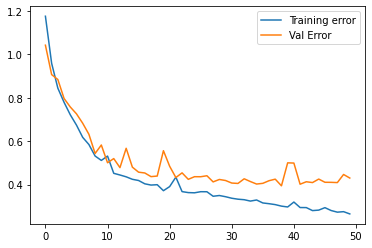

In [79]:
plt.figure()
plt.plot(all_losses, label='Training error')
plt.plot(val_losses, label='Val Error')
plt.legend()

# Retrain

In [80]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset3 = CommonLitDataset(enc_full_training_X, full_training_Y, full_training_lengths)
full_training_generator = torch.utils.data.DataLoader(commonlit_dataset3, **params)

final_model = GRU(hidden_dim).to(device)

epochs = best_val_epoch

criterion = nn.MSELoss()

all_losses = []

start = time.time()

parameters = filter(lambda p: p.requires_grad, final_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    final_model.train()
    for (x, seq_len), y in training_generator: # TODO: Change in full_training_generator (to include the test data)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = final_model(x, seq_len)

        loss = criterion(y_pred, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) MSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 1 | 2% (0m 17s) MSE = 1.2169
Iteration 2 | 5% (0m 34s) MSE = 0.9763
Iteration 3 | 7% (0m 52s) MSE = 0.8738
Iteration 4 | 10% (1m 11s) MSE = 0.7998
Iteration 5 | 12% (1m 28s) MSE = 0.7362
Iteration 6 | 15% (1m 45s) MSE = 0.6769
Iteration 7 | 17% (2m 3s) MSE = 0.6183
Iteration 8 | 20% (2m 21s) MSE = 0.5578
Iteration 9 | 23% (2m 38s) MSE = 0.5604
Iteration 10 | 25% (2m 55s) MSE = 0.4766
Iteration 11 | 28% (3m 13s) MSE = 0.4579
Iteration 12 | 30% (3m 31s) MSE = 0.4386
Iteration 13 | 33% (3m 48s) MSE = 0.4270
Iteration 14 | 35% (4m 6s) MSE = 0.4082
Iteration 15 | 38% (4m 24s) MSE = 0.4187
Iteration 16 | 41% (4m 42s) MSE = 0.3967
Iteration 17 | 43% (5m 0s) MSE = 0.3862
Iteration 18 | 46% (5m 17s) MSE = 0.3881
Iteration 19 | 48% (5m 34s) MSE = 0.3769
Iteration 20 | 51% (5m 52s) MSE = 0.3740
Iteration 21 | 53% (6m 10s) MSE = 0.3699
Iteration 22 | 56% (6m 27s) MSE = 0.3573
Iteration 23 | 58% (6m 44s) MSE = 0.3564
Iteration 24 | 61% (7m 2s) MSE = 0.3451
Iteration 25 | 64% (7m 20s) MSE 

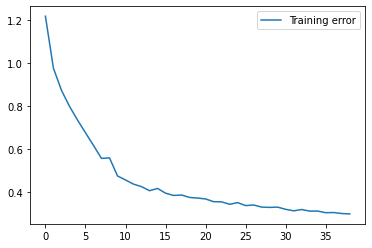

In [81]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.legend()

# Evaluate

In [82]:
test_params = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 0}

internal_test_dataset = CommonLitDataset(enc_test_X, test_Y, test_lengths)
test_generator = torch.utils.data.DataLoader(internal_test_dataset, **test_params)


blind_test_params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}

blind_test_dataset = CommonLitDataset(enc_blind_test_X, np.zeros(enc_blind_test_X.shape), blind_test_lengths)
blind_test_generator = torch.utils.data.DataLoader(blind_test_dataset, **blind_test_params)

# Compute the final MSE on the training set
def compute_squared_error(generator):
    error = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        mse = 0.0
        for (x, seq_len), targets_batch in generator:
            x, targets_batch = x.to(device), targets_batch.to(device)

            batch_size = x.shape[0]

            output = final_model(x, seq_len)

            targets_batch = torch.reshape(targets_batch, (batch_size, 1))

            loss = error(output, targets_batch)
            mse += loss.item()
    return mse
print('Training RMSE =', np.sqrt(compute_squared_error(training_generator) / enc_training_X.shape[0]))
# A bit useless since we train also on this data
print('Internal TEST RMSE =', np.sqrt(compute_squared_error(test_generator) / enc_test_X.shape[0]))
    

Training RMSE = 0.48062843963408564
Internal TEST RMSE = 0.6384047567342714


# Compute outputs

In [83]:
outputs = []
with torch.no_grad():
    for i, ((x, seq_len), targets_batch) in enumerate(blind_test_generator):
        excerpts_batch = x.to(device)

        batch_size = excerpts_batch.shape[0]

        output = final_model(excerpts_batch, seq_len)
        id = blind_test[i, 0]
        print(id, output.item())
        outputs.append((id, output.item()))

# Save outputs to submission.csv
if False:
    with open('submission.csv', 'w') as f:
        f.write('id,target\n')
        for id, o in outputs:
            f.write(id+','+str(o)+'\n')

c0f722661 -1.063838005065918
f0953f0a5 -0.24210666120052338
0df072751 -0.7804214358329773
04caf4e0c -2.6598479747772217
0e63f8bea -2.261051654815674
12537fe78 -1.6240590810775757
965e592c0 0.14499518275260925
